In [1]:
import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import json

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
from nn.utils import gini_tensor, load_numpy, load_image_nopreprocess, show_expl
from nn.utils import gini_numpy, gini_tensor2, gini_tensor_ori, gini_tensor_double
from nn.utils import torch_to_image_ver2, png_to_jpeg, heatmap_to_image
from nn.utils import get_center_attack_matrix, show_expl_title
from nn.imagetool import * # 印各種圖片(灰階 熱點)
import samples.samples as DS
from models.mytool import * # 切換 model 的 function 跟 get_beta
from pytorch.torch_model import TORCH_MODEL
import re #正規表達式 lib
from config import preprocess
import saliency.core as saliency
from PIL import Image
from matplotlib import pylab as P
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

torch.set_printoptions(precision=7) # tensor 小數點後7位
%matplotlib inline 
#要加這一行才有辦法直接用 imshow印出圖片 且只要加一次 所以加在最前面

no display found. Using non-interactive Agg backend


### 基本設定

In [2]:
#from mytool import set_parameter_requires_grad
DATASET = 'imagenet'
MODEL = 'VGG16' # ['RESNET50','_DENSENET121','VGG16','INCEPTIONV3','MOBILENETV2']
img_number = 100
size = 224 #299 # 改變圖片大小 cifar10 原本是32x32
#""""""""""""""""""""""""""""""""""
# resnet 224
# alexnet 224
# vgg 224
# squeezenet 224
# mobilenet 224
# densenet 224
# inception 299
#""""""""""""""""""""""""""""""""""
config_path = '/tf/XAI_Attack/config/model_config.json'
config = json.load(open(config_path))['{}_{}_{}'.format('torch', MODEL, DATASET)]
label_dict = getattr(dataset_label, DATASET)
model_types = re.findall("^([a-z]+)", config['model'])[0]
nb_classes = config['label']
model_tsai = TORCH_MODEL(model_name = MODEL, dataset = DATASET, gpu = torch.cuda.is_available())
ds = getattr(DS, DATASET)
print('ds type: ',type(ds))
print('ds[0] type: ',type(ds[0]),ds[0])
indices = torch.randperm(len(ds.targets))[:img_number].numpy().astype(int) #隨機抽 img_number 張圖
images_list, labels = [np.array(ds[i][0].resize((size,size)).convert('RGB')) for i in indices], [np.array(ds[i][1]) for i in indices]
print('images_list type:',type(images_list))
images_arr, labels = np.array(images_list).astype('float32'), np.array(labels)
print('images_arr type:',type(images_arr),images_arr.shape)
labels_torch = torch.from_numpy(labels)

#images = np.transpose(images, (0, 3, 1, 2)).astype(np.float32) #(3,128,128) #用學長的predict不用在這先變形
#print('images type3:',type(images),images.shape)
#images = Image.fromarray(images)
#print('images type4:',type(images),images.shape)
#images = transform(images)
#print('images type5:',type(images),images.shape)
images = torch.tensor(images_arr)
print('images:',type(images),images.shape)
print('labels:',labels.shape)
print('model:',MODEL)
print('dataset:',DATASET)

ds type:  torchvision.datasets.imagenet.ImageNet
ds[0] type:  <class 'tuple'> (<PIL.Image.Image image mode=RGB size=500x375 at 0x7F128AA423C8>, 0)
images_list type: <class 'list'>
images_arr type: <class 'numpy.ndarray'> (100, 224, 224, 3)
images: <class 'torch.Tensor'> torch.Size([100, 224, 224, 3])
labels: (100,)
model: VGG16
dataset: imagenet


### 讀取圖片

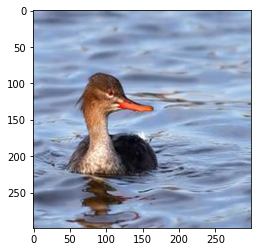

In [3]:
num_iter = 2000
#img = 'data/collie4.jpeg' #要攻擊的圖
#img = 'good_images/example_627_ver2/x.jpeg'
case = '98'
exp_method = 'grad_times_input' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
attack = 'gl' #origin, g, gl, c, cl 
img = 'temp_result/case_'+case+'.jpeg'
red = 'data/RED.jpeg'
target_img = 'data/tiger_cat.jpeg' #要加上去的解釋圖
lr = 0.0002
cuda = True
output_dir = 'temp_result/'
beta_growth = True
prefactors = [1e10, 1e6, 1e-4] # -9 -3 5
device = torch.device("cuda" if cuda else "cpu")
method = getattr(ExplainingMethod, exp_method)
# 確認實驗的圖片
im_orig = LoadImage(img)
P.imshow(im_orig)

### 讀取model

In [4]:
# load model
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
vgg_model = torchvision.models.vgg16(pretrained=True)
#vgg_model = torchvision.models.alexnet(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if beta_growth else None)
#if method == ExplainingMethod.pattern_attribution:
#    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

x_target = load_image(data_mean, data_std, device, target_img)


# load images
#x = load_image(data_mean, data_std, device, img)
x = load_image_nopreprocess(data_mean, data_std, device, img)


x_adv = x.clone().detach().requires_grad_()
print('x',x.shape,type(x))
print('x range',x.min(),x.max())
print('x_adv',x_adv.shape,type(x_adv))
print('x_adv range',x_adv.min(),x_adv.max())

# produce expls
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()
# target attack
target_mtx = get_center_attack_matrix(200, 200, 35, org_expl, 224)
target_mtx_torch = torch.tensor(target_mtx)
target_mtx_torch = target_mtx_torch.view(1,224,224)
target_mtx_torch = target_mtx_torch.to(device)
target_mtx_torch = target_mtx_torch.float()
optimizer = torch.optim.Adam([x_adv], lr=lr)


x torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x range tensor(-2.1179039, device='cuda:0') tensor(2.6400001, device='cuda:0')
x_adv torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x_adv range tensor(-2.1179039, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.6400001, device='cuda:0', grad_fn=<MaxBackward1>)


### 先用實驗模型預測單張樣本

im2.shape:  (224, 224, 3)
im_orig:  (224, 224, 3) <class 'numpy.ndarray'>
im_tensor torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
im_tensor range tensor(-2.1179039, grad_fn=<MinBackward1>) tensor(2.6400001, grad_fn=<MaxBackward1>)
Prediction class: 98
im:  (224, 224, 3) <class 'numpy.ndarray'>
ori_image


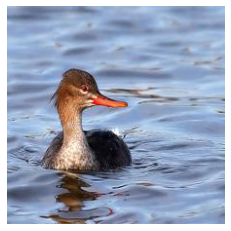

In [5]:
class_idx_str = 'class_idx_str'
im = Image.open(img)
im2 = np.array(im)
im2 = im2.astype(np.float64)
im_orig = im2 #  (224,224,3) 而且這裡的是小數化的整數表示，沒有經過data_mean跟data_sta前處理的
print('im2.shape: ',im2.shape)
im_tensor = PreprocessImages([im_orig])
# Show the image
im_orig_int = np.int_(im_orig) #要從float轉成int才有辦法用ShowImage印出來
ShowImage(im_orig_int)
print('im_orig: ',im_orig.shape, type(im_orig)) # im_orig:  (299, 299, 3) <class 'numpy.ndarray'>
print('im_tensor',im_tensor.shape,type(im_tensor))
print('im_tensor range',im_tensor.min(),im_tensor.max())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
im_tensor = im_tensor.to(device)
predictions = model(im_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
origin_prediction_class = prediction_class
im = im_orig.astype(np.float32)
print('im: ',im.shape, type(im)) # im:  (299, 299, 3) <class 'numpy.ndarray'>
print('ori_image')

### 攻擊開始

In [6]:
loss_gini_list = []
loss_output_list = []
total_loss_list = []
epoch_exp = []
for i in range(num_iter):
    if beta_growth:
        model.change_beta(get_beta(i, num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_gini = F.mse_loss(adv_expl, target_mtx_torch)
    #loss_gini = gini_tensor(adv_expl)
    loss_output = F.mse_loss(adv_acc[0][prediction_class], org_acc[0][prediction_class].detach())
    #print(loss_output)
    #print(adv_expl.device)
    #adv_expl2 = adv_expl.detach().cpu().numpy().flatten()
    #print(adv_expl.device)
    #loss_gini = torch.tensor(gini_numpy(adv_expl2))
    total_loss = prefactors[0]*loss_gini + prefactors[1]*loss_output
    loss_gini_list.append(prefactors[2]*loss_gini.item())
    loss_output_list.append(prefactors[1]*loss_output.item())
    total_loss_list.append(total_loss.item())
    x_tmp = x_adv
    # update adversarial example
    total_loss.backward()
    optimizer.step()
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()
    prediction_class = np.argmax(predictions[0])
    if(prediction_class!=98):
        print('early done')
        x_adv = x_tmp
        break
    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)
    if i == 1:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_gini.item(), loss_output.item()))
    #print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

    if (i+1)%50 == 0:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_gini.item(), loss_output.item()))
        epoch_exp.append(adv_expl)


Iteration 1: Total Loss: 16589.072265625, Gini Loss: 1.6589073084105621e-06, Output Loss: 2.0463630789890885e-12
Iteration 49: Total Loss: 16540.853515625, Gini Loss: 1.6540852811885998e-06, Output Loss: 8.881784197001252e-12
Iteration 99: Total Loss: 16485.193359375, Gini Loss: 1.6485192873005872e-06, Output Loss: 1.1141310096718371e-11
Iteration 149: Total Loss: 16436.927734375, Gini Loss: 1.643692712605116e-06, Output Loss: 1.3656631381309126e-11
Iteration 199: Total Loss: 16401.427734375, Gini Loss: 1.6401427274104208e-06, Output Loss: 9.606537787476555e-12
Iteration 249: Total Loss: 16373.8642578125, Gini Loss: 1.6373863900298602e-06, Output Loss: 6.266986929404084e-12
Iteration 299: Total Loss: 16353.9873046875, Gini Loss: 1.6353986893591355e-06, Output Loss: 4.106937012693379e-12
Iteration 349: Total Loss: 16339.1279296875, Gini Loss: 1.633912802390114e-06, Output Loss: 2.7853275241795927e-12
Iteration 399: Total Loss: 16326.4794921875, Gini Loss: 1.6326479226336232e-06, Output 

### loss curve

gini_loss
logit_loss
total_loss


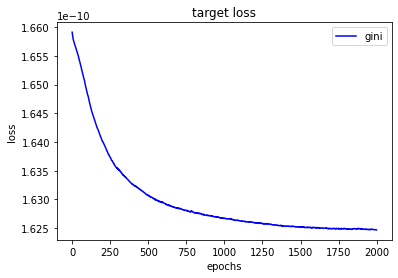

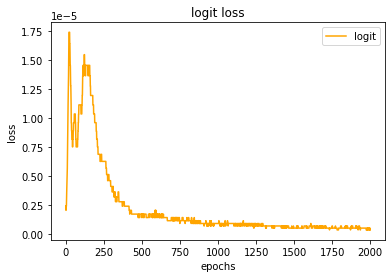

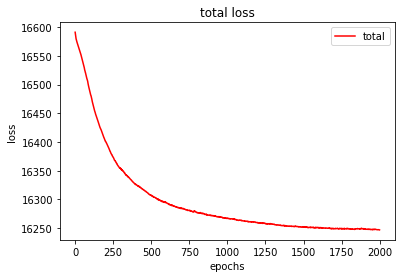

In [7]:
print('gini_loss')
print('logit_loss')
print('total_loss')


plt.title('target loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss_gini_list,label='gini',color='blue')
plt.legend(loc=0) #右上角
plt.show()
plt.close() #關掉比較省空間，這樣重複利用也可以避免memory leak

plt.title('logit loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss_output_list,label='logit',color='orange')
plt.legend(loc=0)
plt.show()
plt.close()

plt.title('total loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(total_loss_list,label='total',color='red')
plt.legend(loc=0)
plt.show()
plt.close()


### 儲存結果

In [8]:
# test with original model (with relu activations)
model.change_beta(None)
adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method)

# save results 並排結果圖
output_dir = make_dir(output_dir)
plot_overview([x_target, x, x_adv], [target_expl, org_expl, adv_expl], data_mean, data_std, filename=f"{output_dir}overview_{exp_method}_gini_{num_iter}.png")
torch.save(x_adv, f"{output_dir}case_{case}_{exp_method}_{attack}_adv.pth")

# 存圖片
x_2, x_noclamp = torch_to_image_ver2(x, data_mean, data_std)
im = Image.fromarray(np.uint8(x_2*255))
im.save(f"{output_dir}case_{case}_{exp_method}_{attack}_ori.jpeg")
# 存擾動過的圖
x_adv_2, x_adv_noclamp = torch_to_image_ver2(x_adv, data_mean, data_std)
im = Image.fromarray(np.uint8(x_adv_2*255))
im.save(f"{output_dir}case_{case}_{exp_method}_{attack}_adv.jpeg")

#norm 變底色的
#cmap 變色調的

#img = Image.open(f"{output_dir}overview_{exp_method}_gini_{num_iter}.png")
#img

torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])


### 原始解釋圖

ori_exp


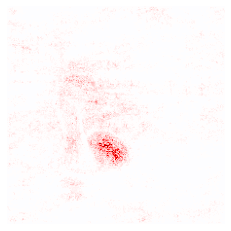

In [9]:
# 目前解釋圖只有辦法存原論文的OAO
# 原始解釋圖
show_expl_title(org_expl, cm= 'seismic')
print('ori_exp')

top10_ori top10_ori_red


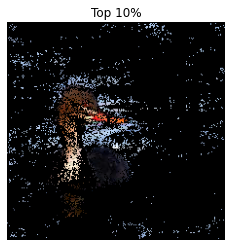

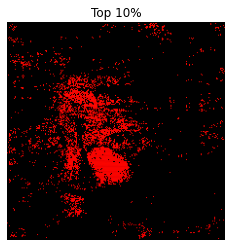

In [10]:
im = Image.open(f"{output_dir}case_{case}_{exp_method}_{attack}_ori.jpeg")
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
org_expl_np = org_expl.detach().cpu().numpy()
mask = org_expl_np > np.percentile(org_expl_np, 90) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')

im = Image.open(red)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
mask = org_expl_np > np.percentile(org_expl_np, 90) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')
print('top10_ori','top10_ori_red')

top30_ori top30_ori_red


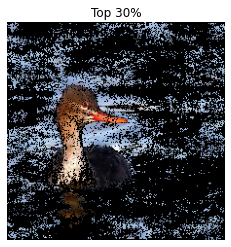

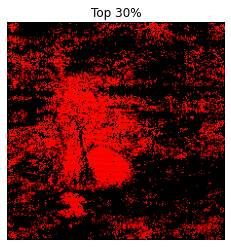

In [11]:
im = Image.open(f"{output_dir}case_{case}_{exp_method}_{attack}_ori.jpeg")
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
org_expl_np = org_expl.detach().cpu().numpy()
mask = org_expl_np > np.percentile(org_expl_np, 70) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 30%')

im = Image.open(red)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
mask = org_expl_np > np.percentile(org_expl_np, 70) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 30%')
print('top30_ori','top30_ori_red')

### 擾動解釋圖

adv_expl


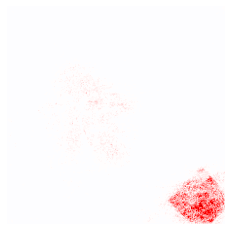

In [12]:
# 擾動解釋圖
show_expl_title(adv_expl, cm = 'seismic')
# autumn, bone, cool, copper, flag, gray, hot, hsv, inferno, 
# jet, magma, pink, plasma, prism, spring, summer, viridis, winter,
print('adv_expl')

top10_adv top10_adv_red


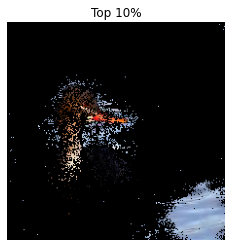

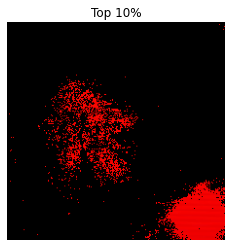

In [13]:
im = Image.open(f"{output_dir}case_{case}_{exp_method}_{attack}_adv.jpeg")
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
adv_expl_np = adv_expl.detach().cpu().numpy()
mask = adv_expl_np > np.percentile(adv_expl_np, 90) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')

im = Image.open(red)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
mask = adv_expl_np > np.percentile(adv_expl_np, 90) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 10%')
print('top10_adv','top10_adv_red')

top30_adv top30_adv_red


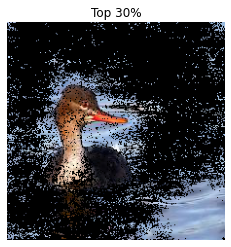

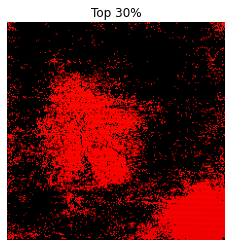

In [14]:
im = Image.open(f"{output_dir}case_{case}_{exp_method}_{attack}_adv.jpeg")
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
adv_expl_np = adv_expl.detach().cpu().numpy()
mask = adv_expl_np > np.percentile(adv_expl_np, 70) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 30%')

im = Image.open(red)
im2 = np.array(im)
im2 = np.resize(im2,(224,224,3))
mask = adv_expl_np > np.percentile(adv_expl_np, 70) #取出指定容器內幾%的值(pr值)
im2[~mask[0]] = 0
ShowImage(im2, 'Top 30%')
print('top30_adv','top30_adv_red')

### 觀察逐步擾動圖

total epochs 2000


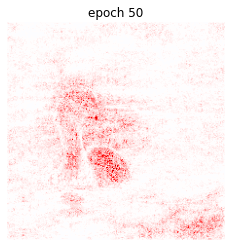

In [15]:
print('total epochs',num_iter)
i = 0
ep = 50 * (i+1)
ep2 = 'epoch ' + str(ep)
show_expl_title(epoch_exp[i], cm = 'seismic', t = ep2)


### 擾動分佈圖

diff


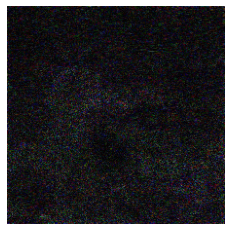

In [16]:
diff = torch.abs(x_adv[0] - x[0])
diff = diff.permute(1,2,0)
diff = diff.detach().cpu()
diff = 3*diff # 不然擾動太小看不到
ShowImage(diff)
print('diff')

### 1.確認output沒有改變 2.用乾淨model看效果 3.換其他model試試遷移性

In [17]:
beta_growth = False
print('beta_growth:',beta_growth)
#vgg_model = torchvision.models.vgg16(pretrained=True)
vgg_model = torchvision.models.alexnet(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if beta_growth else None)
#if method == ExplainingMethod.pattern_attribution:
#    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

predictions = model(x_adv)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}
print("Prediction class: " + str(prediction_class))



beta_growth: False
Prediction class: 98


### 換其他解釋法看遷移性

lrp_adv_exp


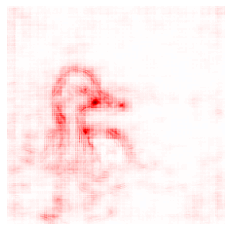

In [18]:
exp_method = 'lrp' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
method = getattr(ExplainingMethod, exp_method)

org_expl2, org_acc2, org_idx2 = get_expl(model, x_adv, method)
org_expl2 = org_expl2.detach().cpu()
show_expl_title(org_expl2, cm= 'seismic')
print(exp_method+'_adv_exp')

guided_backprop_adv_exp


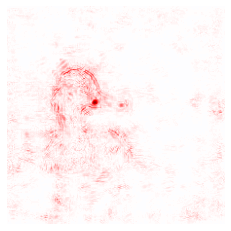

In [19]:
exp_method = 'guided_backprop' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
method = getattr(ExplainingMethod, exp_method)

org_expl2, org_acc2, org_idx2 = get_expl(model, x_adv, method)
org_expl2 = org_expl2.detach().cpu()
show_expl_title(org_expl2, cm= 'seismic')
print(exp_method+'_adv_exp')

gradient_adv_exp


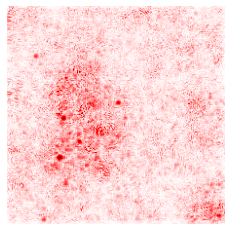

In [20]:
exp_method = 'gradient' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
method = getattr(ExplainingMethod, exp_method)

org_expl2, org_acc2, org_idx2 = get_expl(model, x_adv, method)
org_expl2 = org_expl2.detach().cpu()
show_expl_title(org_expl2, cm= 'seismic')
print(exp_method+'_adv_exp')

integrated_grad_adv_exp


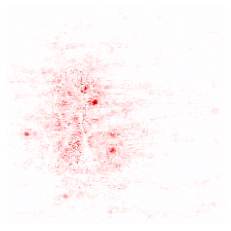

In [21]:
exp_method = 'integrated_grad' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
method = getattr(ExplainingMethod, exp_method)

org_expl2, org_acc2, org_idx2 = get_expl(model, x_adv, method)
org_expl2 = org_expl2.detach().cpu()
show_expl_title(org_expl2, cm= 'seismic')
print(exp_method+'_adv_exp')

grad_times_input_adv_exp


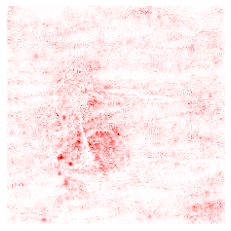

In [22]:
exp_method = 'grad_times_input' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
method = getattr(ExplainingMethod, exp_method)

org_expl2, org_acc2, org_idx2 = get_expl(model, x_adv, method)
org_expl2 = org_expl2.detach().cpu()
show_expl_title(org_expl2, cm= 'seismic')
print(exp_method+'_adv_exp')

### 施工區